### 1. Import Data

Kita mengimport data dari database olist.db, yang di simpan ke dalam 8 dataframe

In [1]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_result(query):
  conn = sqlite3.connect("olist.db")
  cursor = conn.cursor()
  cursor.execute(query)
  data = cursor.fetchall()
  conn.close()
  return data

def create_df(data, columns):
  processData = pd.DataFrame(data=data, columns=columns).drop("index", axis=1)
  # Reset the column index
  processData = processData.reset_index(drop=True)
  # Join the multi-index levels to create a single column index
  processData.columns = [' '.join(col).strip() for col in processData.columns.values]
  return processData

# retrieve all dataset
olistCustomer = create_df(get_result("SELECT * FROM olist_order_customer_dataset"), [["index","customers_id","customers_uniq_id","customers_zip_code_prefix","customer_city","customer_state"]])
olistGeolocation = create_df(get_result("SELECT * FROM olist_geolocation_dataset"), [["index","geolocation_zip_code_prefix","geolocation_lat","geolocation_lng","geolocation_city","geolocation_state"]])
olistOrderItems = create_df(get_result("SELECT * FROM olist_order_items_dataset"), [["index","order_id","order_item_id","product_id","seller_id","shipping_limit_date","price","freight_value"]])
olistOrderPayments = create_df(get_result("SELECT * FROM olist_order_payments_dataset"), [["index","order_id","payment_sequential","payment_type","payment_installments","payment_value"]])
olistOrderReview = create_df(get_result("SELECT * FROM olist_order_reviews_dataset"), [["index","review_id","order_id","review_score","review_comment_title","review_comment_message","review_creation_date","review_answer_timestamp"]])
olistOrders = create_df(get_result("SELECT * FROM olist_order_dataset"), [["index","order_id","customer_id","order_status","order_purchase_timestamp","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date"]])
olistProducts = create_df(get_result("SELECT * FROM olist_products_dataset"), [["index","product_id","product_category_name","product_name_length","product_description_length","product_photos_qty","product_weight_g","product_length_cm","product_height_cm","product_width_cm"]])
olistSeller = create_df(get_result("SELECT * FROM olist_sellers_dataset"), [["index","seller_id","seller_zip_code_prefix","seller_city","seller_state"]])

### 2. Join Table

memproses join/merging dataframe yang ada, krn beberapa field yang di perlukan tersimpan dalam beberapa dataframe yang di hubungkan dengan primary key atau foreign key

In [4]:
merged_df = pd.merge(pd.merge(pd.merge(olistOrderItems, olistProducts, on="product_id", how="left"),olistOrders, on="order_id", how="left"),olistOrderPayments,on="order_id", how="left")
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117604 entries, 0 to 117603
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117604 non-null  object 
 1   order_item_id                  117604 non-null  int64  
 2   product_id                     117604 non-null  object 
 3   seller_id                      117604 non-null  object 
 4   shipping_limit_date            117604 non-null  object 
 5   price                          117604 non-null  float64
 6   freight_value                  117604 non-null  float64
 7   product_category_name          115906 non-null  object 
 8   product_name_length            115906 non-null  float64
 9   product_description_length     115906 non-null  float64
 10  product_photos_qty             115906 non-null  float64
 11  product_weight_g               117584 non-null  float64
 12  product_length_cm             

In [5]:
# Ringkas ke field of concern saja
fields_use = ["order_id","price","product_category_name","order_status","order_purchase_timestamp","payment_type","payment_installments"]
merged_df = merged_df[fields_use]
# dtype untuk filed order_purchase_timestamp perlu di casting ke datetime format data type
merged_df["order_purchase_timestamp"] = pd.to_datetime(merged_df["order_purchase_timestamp"])
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117604 entries, 0 to 117603
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  117604 non-null  object        
 1   price                     117604 non-null  float64       
 2   product_category_name     115906 non-null  object        
 3   order_status              117604 non-null  object        
 4   order_purchase_timestamp  117604 non-null  datetime64[ns]
 5   payment_type              117601 non-null  object        
 6   payment_installments      117601 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 6.3+ MB


In [6]:
# Kita hanya menggunakan record yang memiliki status : delivered (97.8225%) dan shipped saja (1.0578%)
# proses akan me-ringkas dataset merge kita menjadi 116282 records saja
merged_df["order_status"].value_counts(normalize = True)
status_order = ["delivered","shipped"]
merged_df = merged_df[merged_df["order_status"].isin(status_order)]
merged_df.shape

(116282, 7)

### 3.1. Missing values

Kita melakukan pemeriksaan missing value dari ke 7 field yang ada.

In [7]:
# Numerator untuk missing value yang di atas 0
missing_numerator = merged_df.isnull().sum()[merged_df.isnull().sum() > 0]
# Buat dataframe dari 2 buah Series
missing_df = pd.DataFrame({'NaN_Count': missing_numerator, 'NaN_Percentage': (missing_numerator / len(merged_df)*100)}).sort_values(by = 'NaN_Percentage', ascending = False)
missing_df

,NaN_Count,NaN_Percentage
product_category_name,1658,1.425844
payment_type,3,0.002580
payment_installments,3,0.002580


In [8]:
# nilai NaN dari tiap field di atas memiliki persentase yang kecil sekali terhadap overall data (kurang dari 3%)
# product_category_name
imputer = SimpleImputer(missing_values=None, strategy='most_frequent')
merged_df["product_category_name"] = imputer.fit_transform(merged_df["product_category_name"].values.reshape(-1,1))[:,0]
# untuk nilai payment_type dan payment_installments, karena persentase nya sangat kecil, kita akan drop saja record tersebut
merged_df.dropna(subset=["payment_type","payment_installments"], inplace=True)
merged_df

,order_id,price,product_category_name,order_status,order_purchase_timestamp,payment_type,payment_installments
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,cool_stuff,delivered,2017-09-13 08:59:02,credit_card,2.0
1,00018f77f2f0320c557190d7a144bdd3,239.90,pet_shop,delivered,2017-04-26 10:53:06,credit_card,3.0
2,000229ec398224ef6ca0657da4fc703e,199.00,moveis_decoracao,delivered,2018-01-14 14:33:31,credit_card,5.0
3,00024acbcdf0a6daa1e931b038114c75,12.99,perfumaria,delivered,2018-08-08 10:00:35,credit_card,2.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,ferramentas_jardim,delivered,2017-02-04 13:57:51,credit_card,3.0
...,...,...,...,...,...,...,...
117599,fffc94f6ce00a00581880bf54a75a037,299.99,utilidades_domesticas,delivered,2018-04-23 13:57:06,boleto,1.0
117600,fffcd46ef2263f404302a634eb57f7eb,350.00,informatica_acessorios,delivered,2018-07-14 10:26:46,boleto,1.0
117601,fffce4705a9662cd70adb13d4a31832d,99.90,esporte_lazer,delivered,2017-10-23 17:07:56,credit_card,3.0
117602,fffe18544ffabc95dfada21779c9644f,55.99,informatica_acessorios,delivered,2017-08-14 23:02:59,credit_card,3.0


In [9]:
# Pemeriksaan ulang untuk NaN
missing_numerator = merged_df.isnull().sum()[merged_df.isnull().sum() > 0]
# Buat dataframe dari 2 buah Series
missing_df = pd.DataFrame({'NaN_Count': missing_numerator, 'NaN_Percentage': (missing_numerator / len(merged_df)*100)}).sort_values(by = 'NaN_Percentage', ascending = False)
missing_df

,NaN_Count,NaN_Percentage


### 3.2. Handling Outliers

Outliers biasa di temukan pada data numerical (price dan payment installments)

In [10]:
def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    print("Lower Bound : ",lwr_bound, " Upper Bound : ", upr_bound)
    for i in data:
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

outliers_fields = ["price","payment_installments"]

for i in outliers_fields:
    outlier = detect_outliers_iqr(merged_df[i])
    print(f"Jumlah outliers di field : {str(i).upper()} adalah: {len(outlier)}")
    print()

Lower Bound :  -101.24999999999997  Upper Bound :  275.15
Jumlah outliers di field : PRICE adalah: 8688

Lower Bound :  -3.5  Upper Bound :  8.5
Jumlah outliers di field : PAYMENT_INSTALLMENTS adalah: 7888



Text(0.5, 0, 'frekuensi')

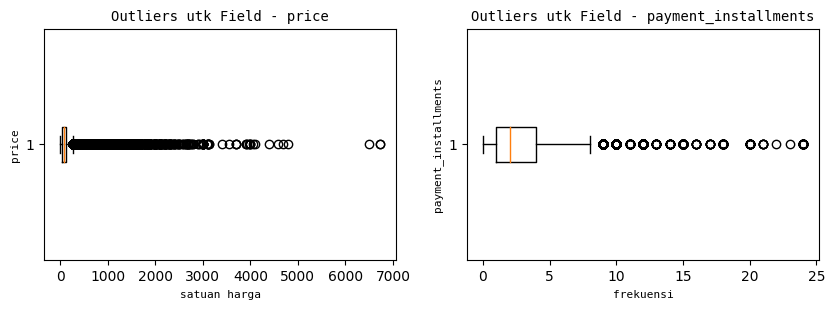

In [11]:
# Visualisasi untuk BoxPlot
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 2,  
                       figsize = (10, 3))

ax[0].boxplot(merged_df[outliers_fields[0]], vert=False)
ax[0].set_title(str(outliers_fields[0]), fontdict={'fontsize':12})
ax[0].set_title("Outliers utk Field - price", 
                fontsize = 10, 
                fontfamily = 'monospace')
ax[0].set_ylabel("price", 
                 fontsize = 8, 
                 fontfamily = 'monospace')
ax[0].set_xlabel("satuan harga", 
                 fontsize = 8, 
                 fontfamily = 'monospace')

ax[1].boxplot(merged_df[outliers_fields[1]], vert=False)
ax[1].set_title(str(outliers_fields[1]), fontdict={'fontsize':12})
ax[1].set_title("Outliers utk Field - payment_installments", 
                fontsize = 10, 
                fontfamily = 'monospace')
ax[1].set_ylabel("payment_installments", 
                 fontsize = 8, 
                 fontfamily = 'monospace')
ax[1].set_xlabel("frekuensi", 
                 fontsize = 8, 
                 fontfamily = 'monospace')

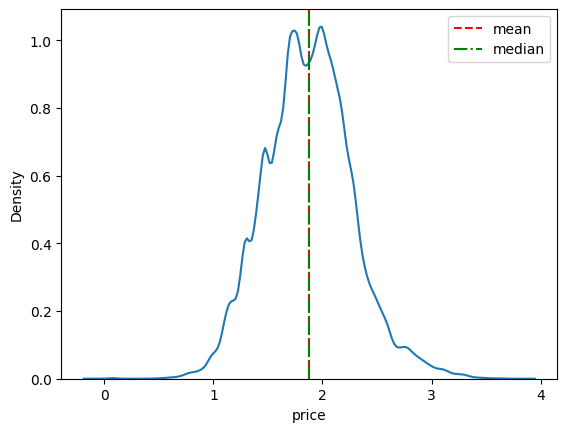

In [102]:
# untuk field - payment installments kita tidak akan "treat" karena nilai yg di anggap outliers sebenar nya memang masih dalam kewajaran
# Kita hanya akan men treat outliers di field price saja
# Jika kita visualisasikan secara histogram
df_viz = merged_df.copy()
df_viz["price"] = np.log10(df_viz["price"])
#sns.histplot(data = merged_df, x = "price", stat="density")
sns.kdeplot(data = df_viz, x = "price")
plt.axvline(x=df_viz["price"].mean(), color="r", linestyle="--", label="mean")
plt.axvline(x=df_viz["price"].median(), color="g", linestyle="-.", label="median")
plt.legend()
plt.show()

In [12]:
# Tampak data skewed ke kiri (negative skew)
merged_df.loc[merged_df["price"]>(merged_df["price"].quantile(0.75)*1.5), "price"] = merged_df['price'].median()
merged_df["price"].describe()

count    116279.000000
mean         76.104921
std          45.717386
min           0.850000
25%          39.900000
50%          74.900000
75%          99.900000
max         201.000000
Name: price, dtype: float64

### 3.3. Handling Duplicates

In [13]:
# Memeriksa record yang duplicates
merged_df[merged_df.duplicated(keep=False)]

,order_id,price,product_category_name,order_status,order_purchase_timestamp,payment_type,payment_installments
13,0008288aa423d2a3f00fcb17cd7d8719,49.90,ferramentas_jardim,delivered,2018-02-13 22:10:21,boleto,1.0
14,0008288aa423d2a3f00fcb17cd7d8719,49.90,ferramentas_jardim,delivered,2018-02-13 22:10:21,boleto,1.0
32,00143d0f86d6fbd9f9b38ab440ac16f5,21.33,esporte_lazer,delivered,2017-10-16 15:29:43,credit_card,1.0
33,00143d0f86d6fbd9f9b38ab440ac16f5,21.33,esporte_lazer,delivered,2017-10-16 15:29:43,credit_card,1.0
34,00143d0f86d6fbd9f9b38ab440ac16f5,21.33,esporte_lazer,delivered,2017-10-16 15:29:43,credit_card,1.0
...,...,...,...,...,...,...,...
117589,fff8287bbae429a99bb7e8c21d151c41,180.00,informatica_acessorios,delivered,2018-03-17 12:11:45,credit_card,4.0
117594,fffb9224b6fc7c43ebb0904318b10b5f,55.00,relogios_presentes,delivered,2017-10-27 16:51:00,boleto,1.0
117595,fffb9224b6fc7c43ebb0904318b10b5f,55.00,relogios_presentes,delivered,2017-10-27 16:51:00,boleto,1.0
117596,fffb9224b6fc7c43ebb0904318b10b5f,55.00,relogios_presentes,delivered,2017-10-27 16:51:00,boleto,1.0


In [14]:
# Data duplicate kita hilangkan dengan mempertahankan record yang pertama saja
merged_df = merged_df.drop_duplicates(keep="first")
merged_df[merged_df.duplicated(keep=False)]

,order_id,price,product_category_name,order_status,order_purchase_timestamp,payment_type,payment_installments


### 3.4. Handling Incosistency Data

In [15]:
# Dari data yang ada, kita cek inkosistensi dari field category
pd.set_option('display.max_rows', 75)
merged_df["product_category_name"].value_counts().sort_index()

product_category_name
agro_industria_e_comercio                           186
alimentos                                           452
alimentos_bebidas                                   228
artes                                               206
artes_e_artesanato                                   24
artigos_de_festas                                    40
artigos_de_natal                                    128
audio                                               361
automotivo                                         4025
bebes                                              2943
bebidas                                             299
beleza_saude                                       9005
brinquedos                                         3975
cama_mesa_banho                                   11530
casa_conforto                                       407
casa_conforto_2                                      25
casa_construcao                                     508
cds_dvds_musicais         

In [16]:
# records dengan suffix angka kita asumsikan sebagai data inconsistency

pd.reset_option('all')
map_inkonsistent = {
    "casa_conforto_2" : "casa_conforto",
    "eletrodomesticos_2" : "eletrodomesticos",
}
merged_df["product_category_name"] = merged_df["product_category_name"].replace(map_inkonsistent)

In [17]:
merged_df

,order_id,price,product_category_name,order_status,order_purchase_timestamp,payment_type,payment_installments
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,cool_stuff,delivered,2017-09-13 08:59:02,credit_card,2.0
1,00018f77f2f0320c557190d7a144bdd3,74.90,pet_shop,delivered,2017-04-26 10:53:06,credit_card,3.0
2,000229ec398224ef6ca0657da4fc703e,199.00,moveis_decoracao,delivered,2018-01-14 14:33:31,credit_card,5.0
3,00024acbcdf0a6daa1e931b038114c75,12.99,perfumaria,delivered,2018-08-08 10:00:35,credit_card,2.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,ferramentas_jardim,delivered,2017-02-04 13:57:51,credit_card,3.0
...,...,...,...,...,...,...,...
117599,fffc94f6ce00a00581880bf54a75a037,74.90,utilidades_domesticas,delivered,2018-04-23 13:57:06,boleto,1.0
117600,fffcd46ef2263f404302a634eb57f7eb,74.90,informatica_acessorios,delivered,2018-07-14 10:26:46,boleto,1.0
117601,fffce4705a9662cd70adb13d4a31832d,99.90,esporte_lazer,delivered,2017-10-23 17:07:56,credit_card,3.0
117602,fffe18544ffabc95dfada21779c9644f,55.99,informatica_acessorios,delivered,2017-08-14 23:02:59,credit_card,3.0


### 4. Analysis

**4.1 Produk category yang memberikan sumbangan besar bagi penjualan**

Jika kita lihat tampak penjualan produk dari kategori cama_mesa_banho (kamar mandi/tidur), merupakan category penjualan tertinggi

Namun, jika kita uraikan ke penjualan per perioda (dalam hal ini satuan tahun), di dapatkan hasil yang berbeda 

In [18]:
analytics1 = pd.DataFrame(merged_df.groupby(["product_category_name"])["price"].sum())
analytics1.sort_values('price', ascending=False).head(10)

,price
product_category_name,
cama_mesa_banho,936214.28
beleza_saude,685176.54
esporte_lazer,640840.28
informatica_acessorios,567171.09
relogios_presentes,550671.77
moveis_decoracao,500906.71
utilidades_domesticas,430439.19
cool_stuff,360293.79
automotivo,323320.25


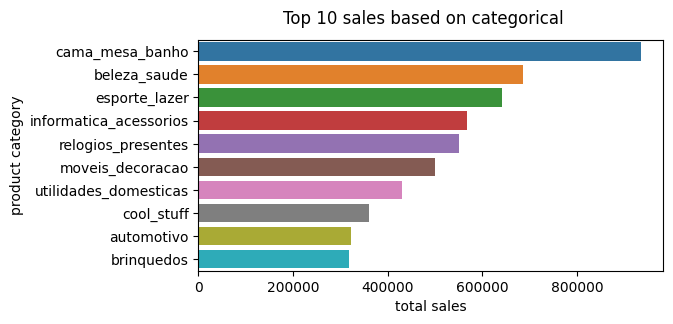

In [19]:
fig, ax = plt.subplots(figsize = (6, 3))

# Buat barplot persentase NaN tiap kolom
sns.barplot(data = analytics1.sort_values('price', ascending=False).head(10).T,
            orient = "h",
            ax = ax)
fig.suptitle("Top 10 sales based on categorical")
ax.set_ylabel("product category")
ax.set_xlabel("total sales")
plt.show()

In [20]:
# Tetapi jika kita detail kan, tampak perjualan tahunan yg terbesar urutan ke 3 berbeda
# karena jika kita rincikan per tahun, yearly sales akan berbeda (ada beberapa produk yang berusia berbeda)

pd.set_option('display.max_rows', 25)
merged_df["timestamp_year"] = merged_df["order_purchase_timestamp"].dt.year
cm = sns.light_palette("green", as_cmap=True)
merged_df.pivot_table(values=['price'], index=['product_category_name', 'timestamp_year'], aggfunc={'price':np.sum}).sort_values(by='price', ascending=False).style.background_gradient(cmap=cm)

In [21]:
list1=[]
for i in analytics1.sort_values('price', ascending=False).head(10).index:
    list1.append(i)
merged_viz1 = merged_df[merged_df["product_category_name"].isin(list1)][["product_category_name","order_purchase_timestamp","price"]]
merged_viz1

,product_category_name,order_purchase_timestamp,price
0,cool_stuff,2017-09-13 08:59:02,58.90
2,moveis_decoracao,2018-01-14 14:33:31,199.00
5,utilidades_domesticas,2017-05-15 21:42:34,21.90
8,beleza_saude,2018-03-19 18:40:33,145.95
10,beleza_saude,2018-03-24 22:16:10,59.99
...,...,...,...
117599,utilidades_domesticas,2018-04-23 13:57:06,74.90
117600,informatica_acessorios,2018-07-14 10:26:46,74.90
117601,esporte_lazer,2017-10-23 17:07:56,99.90
117602,informatica_acessorios,2017-08-14 23:02:59,55.99


In [22]:
merged_viz1["year"] = merged_viz1["order_purchase_timestamp"].dt.year
merged_viz1["month"] = merged_viz1["order_purchase_timestamp"].dt.month
merged_viz1.pivot_table(values="price", index=["month","year"], columns=["product_category_name"],aggfunc='sum', fill_value=0)
merged_viz1

,product_category_name,order_purchase_timestamp,price,year,month
0,cool_stuff,2017-09-13 08:59:02,58.90,2017,9
2,moveis_decoracao,2018-01-14 14:33:31,199.00,2018,1
5,utilidades_domesticas,2017-05-15 21:42:34,21.90,2017,5
8,beleza_saude,2018-03-19 18:40:33,145.95,2018,3
10,beleza_saude,2018-03-24 22:16:10,59.99,2018,3
...,...,...,...,...,...
117599,utilidades_domesticas,2018-04-23 13:57:06,74.90,2018,4
117600,informatica_acessorios,2018-07-14 10:26:46,74.90,2018,7
117601,esporte_lazer,2017-10-23 17:07:56,99.90,2017,10
117602,informatica_acessorios,2017-08-14 23:02:59,55.99,2017,8


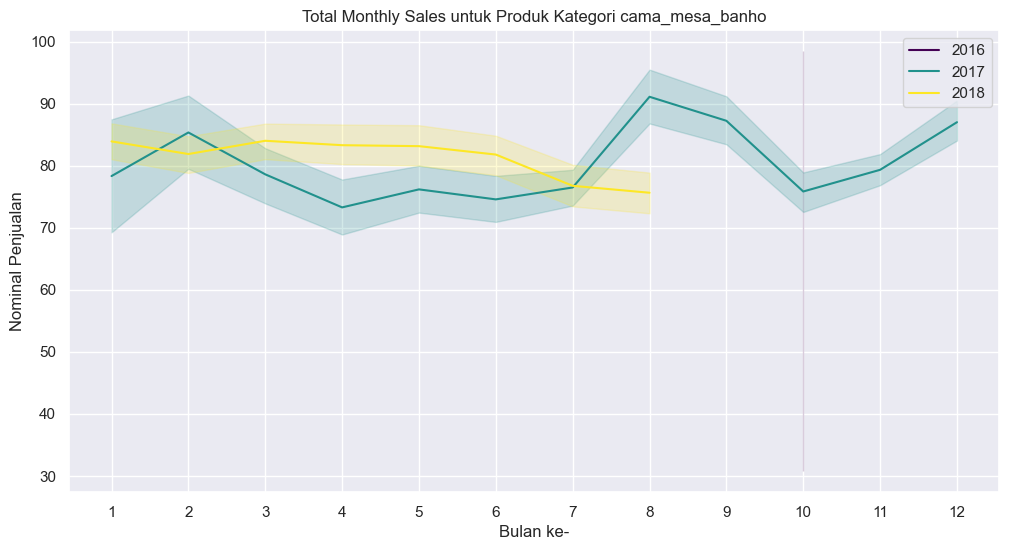

** Terlihat data penjualan untuk kategori cama_mesa_banho relatif stabil dari tahun ke tahun


In [24]:
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

viz2 = merged_viz1[merged_viz1["product_category_name"]=="cama_mesa_banho"]
sns.set_style('darkgrid') # style 
sns.set(rc={'figure.figsize':(12,6)}) # mengatur ukuran gambar
ax = sns.lineplot(data=viz2, x ='month', y = 'price',
                  hue = "year", palette='viridis',
                  legend='full') # membuat lineplot
ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) #mengatur sumbu x bertambah 1
plt.title('Total Monthly Sales untuk Produk Kategori cama_mesa_banho')
plt.legend(bbox_to_anchor=(1, 1))      # membuat legend
plt.ylabel('Nominal Penjualan')
plt.xlabel('Bulan ke-')
plt.show()
print("** Terlihat data penjualan untuk kategori cama_mesa_banho relatif stabil dari tahun ke tahun")

**4.2 Jenis Pembayaran Yang Umum nya di Gunakan**

Tampak di bawah, jenis pembayaran credit_card yang paling banyak di pakai, di ikuti Boleto (cash payment method)

In [25]:
pd.pivot_table(merged_df,values="order_status", index="payment_type", columns = "timestamp_year",aggfunc='count', fill_value=0)

timestamp_year,2016,2017,2018
payment_type,,,
boleto,52,9477,10338
credit_card,222,34524,42608
debit_card,2,420,1126
voucher,10,1927,1887


**4.3 Jumlah Installment**

In [26]:
pd.pivot_table(merged_df,values="order_status", index="payment_installments", columns = "timestamp_year",aggfunc='count', fill_value=0)

timestamp_year,2016,2017,2018
payment_installments,,,
0.0,0,0,2
1.0,115,21991,28461
2.0,26,5339,7078
3.0,37,4900,5584
4.0,22,3378,3776
5.0,16,2577,2709
6.0,16,1900,2088
7.0,10,844,788
8.0,3,1762,2632
